# Extra layers

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder, QuantileTransformer, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split 

from numpy.lib.stride_tricks import sliding_window_view

import tensorflow as tf
from tensorflow import keras

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
from IPython.display import display

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
df = pd.read_csv('GOOGL.csv')
df.Date = pd.to_numeric(pd.to_datetime(df.Date, format='%Y-%m-%d'))
df.pop('Adj Close')

0         50.220219
1         54.209209
2         54.754753
3         52.487488
4         53.053055
           ...     
4426    2722.510010
4427    2722.030029
4428    2797.360107
4429    2765.510010
4430    2831.439941
Name: Adj Close, Length: 4431, dtype: float64

In [6]:
df.describe()

,Date,Open,High,Low,Close,Volume
count,4.431000e+03,4431.000000,4431.000000,4431.000000,4431.000000,4.431000e+03
mean,1.370505e+18,693.087345,699.735595,686.078751,693.097367,6.444992e+06
std,1.603781e+17,645.118799,651.331215,638.579488,645.187806,7.690351e+06
min,1.092874e+18,49.644646,50.920921,48.028027,50.055054,4.656000e+05
25%,1.231762e+18,248.558563,250.853355,245.813309,248.415916,1.695600e+06
50%,1.370563e+18,434.924927,437.887878,432.687683,435.330322,3.778418e+06
75%,1.509192e+18,1007.364990,1020.649994,997.274994,1007.790008,8.002390e+06
max,1.648080e+18,3025.000000,3030.929932,2977.979980,2996.770020,8.215117e+07


## Setup

In [7]:
def prepare_data_partial(data, scaler, window_size=50, train=True):
    scaled_data = scaler.fit_transform(data) if train else scaler.transform(data)
    input_data = sliding_window_view(scaled_data, window_size, axis=0).transpose(0,2,1)[:-1]
    output_data = scaled_data[window_size:,1]
    output_data = np.reshape(output_data, (-1,1))
    return (input_data, output_data)
    
def prepare_data(data, scaler, split=0.9, window_size=50):
    train_size = int(split*len(data))
    
    train = data[:train_size]
    test = data[train_size:]
    
    preped_train = prepare_data_partial(train, scaler, window_size, True)
    preped_test = prepare_data_partial(test, scaler, window_size, True)
    return (preped_train, preped_test)

In [8]:
mae = keras.losses.MeanAbsoluteError()
mse = keras.losses.MeanSquaredError()
hub = keras.losses.Huber()

def eval_model(model, history, type, loss='mae', optimizer='AdamW'):
    y_pred = model.predict(X_test)
    res = pd.DataFrame({'Test': y_test.ravel(), 'Predicted': y_pred.ravel()})
    sns.lineplot(res, dashes=False)
    plt.show()
    
    pd.DataFrame(history.history).plot()
    plt.show()

    return {
        'type': type,
        'best_val_loss': min(history.history['val_loss']),
        'loss_method': loss,
        'optimizer': optimizer,
        'mae': mae(y_test, y_pred).numpy(),
        'mse': mse(y_test, y_pred).numpy(),
        'huber': hub(y_test, y_pred).numpy(),
    }

def res_to_table(result):
    return pd.DataFrame.from_dict(result, orient='index').T

In [9]:
results = []

In [10]:
scaler = MinMaxScaler((-1,1))
data = np.array(df)
((X_train, y_train), (X_test, y_test)) = prepare_data(data, scaler)

In [32]:
net_num = 1
def test_network(layers, epochs=500, lr_pat=30, es_pat=50):
    model = tf.keras.models.Sequential(layers)

    batch_size = 128
    
    callbacks = [
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=lr_pat, min_lr=0.0001),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=es_pat, restore_best_weights=True, verbose=1),
    ]
    model.compile(
        optimizer=keras.optimizers.AdamW(),
        loss='mae',
    )
    history = model.fit(
        X_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks,
        validation_split=0.2,
        verbose=1,
    )

    global net_num
    res = eval_model(model, history, f'Network{net_num}')
    net_num = net_num + 1
    display(res_to_table(res))
    results.append(res)
    return model

## Testiranje

Epoch 1/500
25/25 [==============================] - 2s 16ms/step - loss: 0.2604 - val_loss: 0.8754 - lr: 0.0010
Epoch 2/500
25/25 [==============================] - 0s 5ms/step - loss: 0.0580 - val_loss: 0.8725 - lr: 0.0010
Epoch 3/500
25/25 [==============================] - 0s 5ms/step - loss: 0.0384 - val_loss: 0.7835 - lr: 0.0010
Epoch 4/500
25/25 [==============================] - 0s 5ms/step - loss: 0.0391 - val_loss: 0.7080 - lr: 0.0010
Epoch 5/500
25/25 [==============================] - 0s 5ms/step - loss: 0.0365 - val_loss: 0.5364 - lr: 0.0010
Epoch 6/500
25/25 [==============================] - 0s 5ms/step - loss: 0.0340 - val_loss: 0.6095 - lr: 0.0010
Epoch 7/500
25/25 [==============================] - 0s 5ms/step - loss: 0.0310 - val_loss: 0.5929 - lr: 0.0010
Epoch 8/500
25/25 [==============================] - 0s 5ms/step - loss: 0.0329 - val_loss: 0.4549 - lr: 0.0010
Epoch 9/500
25/25 [==============================] - 0s 5ms/step - loss: 0.0299 - val_loss: 0.4341 - lr

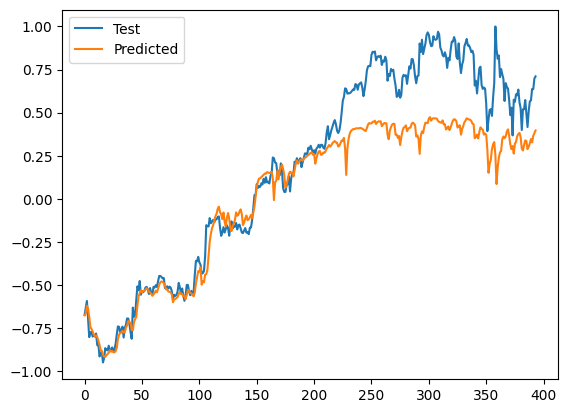

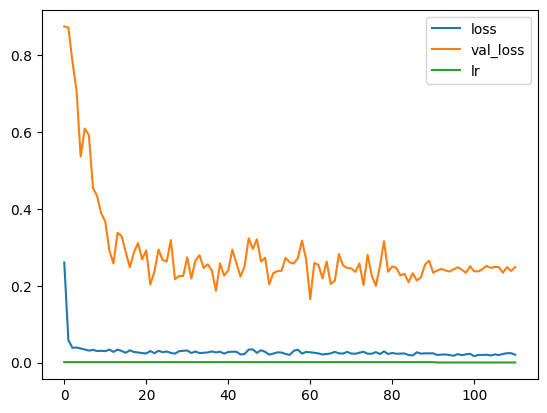

,type,best_val_loss,loss_method,optimizer,mae,mse,huber
0,Network1,0.16498,mae,AdamW,0.173142,0.057651,0.028825


In [24]:
test_network([
    keras.layers.Input(shape=(50,6)),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(50),
    keras.layers.Dense(1),
])

Epoch 1/500
25/25 [==============================] - 2s 17ms/step - loss: 0.4686 - val_loss: 0.5995 - lr: 0.0010
Epoch 2/500
25/25 [==============================] - 0s 5ms/step - loss: 0.2256 - val_loss: 0.8473 - lr: 0.0010
Epoch 3/500
25/25 [==============================] - 0s 5ms/step - loss: 0.0679 - val_loss: 0.9673 - lr: 0.0010
Epoch 4/500
25/25 [==============================] - 0s 5ms/step - loss: 0.0518 - val_loss: 0.9049 - lr: 0.0010
Epoch 5/500
25/25 [==============================] - 0s 5ms/step - loss: 0.0501 - val_loss: 0.9649 - lr: 0.0010
Epoch 6/500
25/25 [==============================] - 0s 5ms/step - loss: 0.0413 - val_loss: 0.9503 - lr: 0.0010
Epoch 7/500
25/25 [==============================] - 0s 5ms/step - loss: 0.0328 - val_loss: 0.9226 - lr: 0.0010
Epoch 8/500
25/25 [==============================] - 0s 5ms/step - loss: 0.0339 - val_loss: 0.9149 - lr: 0.0010
Epoch 9/500
25/25 [==============================] - 0s 6ms/step - loss: 0.0366 - val_loss: 0.8897 - lr

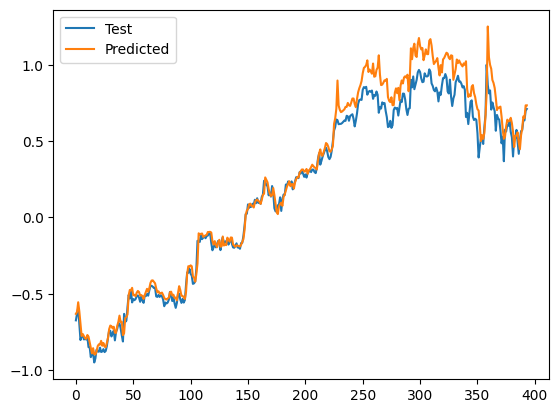

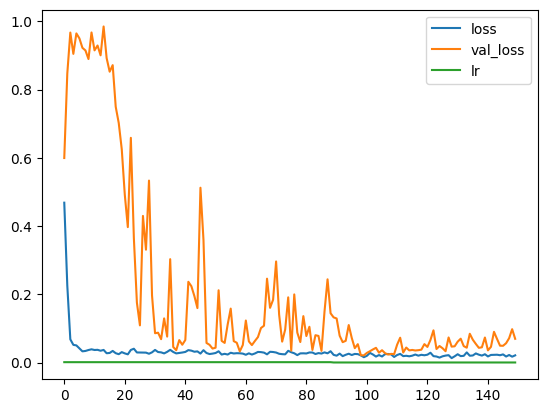

,type,best_val_loss,loss_method,optimizer,mae,mse,huber
0,Network2,0.020898,mae,AdamW,0.074067,0.010983,0.005492


In [25]:
test_network([
    keras.layers.Input(shape=(50,6)),
    keras.layers.LSTM(50),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1),
])

Epoch 1/500
25/25 [==============================] - 2s 16ms/step - loss: 0.1940 - val_loss: 0.0457 - lr: 0.0010
Epoch 2/500
25/25 [==============================] - 0s 5ms/step - loss: 0.0585 - val_loss: 0.0472 - lr: 0.0010
Epoch 3/500
25/25 [==============================] - 0s 5ms/step - loss: 0.0502 - val_loss: 0.0353 - lr: 0.0010
Epoch 4/500
25/25 [==============================] - 0s 5ms/step - loss: 0.0425 - val_loss: 0.0315 - lr: 0.0010
Epoch 5/500
25/25 [==============================] - 0s 5ms/step - loss: 0.0383 - val_loss: 0.0376 - lr: 0.0010
Epoch 6/500
25/25 [==============================] - 0s 5ms/step - loss: 0.0363 - val_loss: 0.0315 - lr: 0.0010
Epoch 7/500
25/25 [==============================] - 0s 5ms/step - loss: 0.0359 - val_loss: 0.0295 - lr: 0.0010
Epoch 8/500
25/25 [==============================] - 0s 5ms/step - loss: 0.0332 - val_loss: 0.0292 - lr: 0.0010
Epoch 9/500
25/25 [==============================] - 0s 5ms/step - loss: 0.0313 - val_loss: 0.0296 - lr

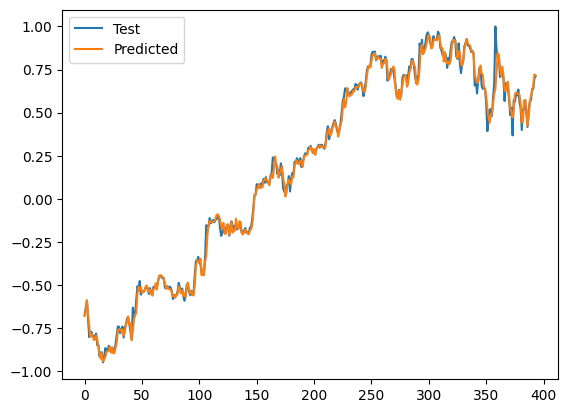

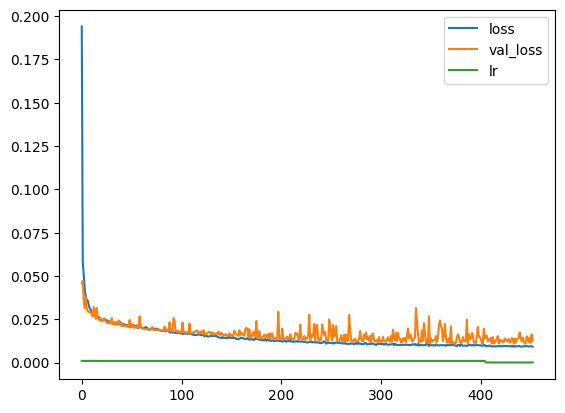

,type,best_val_loss,loss_method,optimizer,mae,mse,huber
0,Network3,0.011006,mae,AdamW,0.023143,0.00138,0.00069


In [26]:
test_network([
    keras.layers.Input(shape=(50,6)),
    keras.layers.LSTM(50),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(1),
])

Epoch 1/500
25/25 [==============================] - 3s 28ms/step - loss: 0.1098 - val_loss: 0.1363 - lr: 0.0010
Epoch 2/500
25/25 [==============================] - 0s 8ms/step - loss: 0.0312 - val_loss: 0.1011 - lr: 0.0010
Epoch 3/500
25/25 [==============================] - 0s 7ms/step - loss: 0.0230 - val_loss: 0.1198 - lr: 0.0010
Epoch 4/500
25/25 [==============================] - 0s 7ms/step - loss: 0.0220 - val_loss: 0.1265 - lr: 0.0010
Epoch 5/500
25/25 [==============================] - 0s 6ms/step - loss: 0.0193 - val_loss: 0.1188 - lr: 0.0010
Epoch 6/500
25/25 [==============================] - 0s 10ms/step - loss: 0.0189 - val_loss: 0.1061 - lr: 0.0010
Epoch 7/500
25/25 [==============================] - 0s 7ms/step - loss: 0.0182 - val_loss: 0.1030 - lr: 0.0010
Epoch 8/500
25/25 [==============================] - 0s 6ms/step - loss: 0.0175 - val_loss: 0.1033 - lr: 0.0010
Epoch 9/500
25/25 [==============================] - 0s 6ms/step - loss: 0.0187 - val_loss: 0.0932 - l

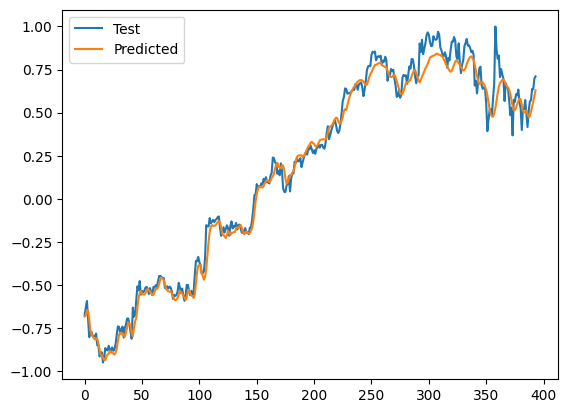

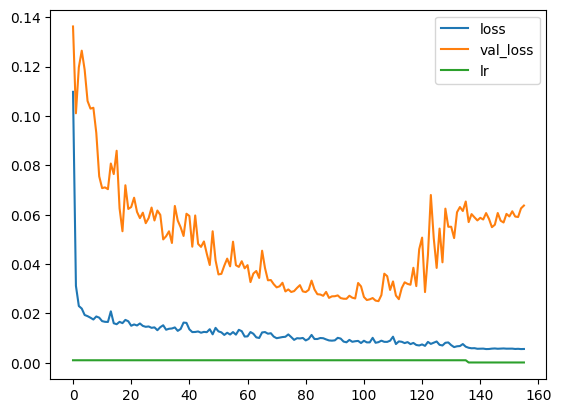

,type,best_val_loss,loss_method,optimizer,mae,mse,huber
0,Network4,0.024958,mae,AdamW,0.050096,0.005124,0.002562


In [28]:
test_network([
    keras.layers.Input(shape=(50,6)),
    keras.layers.LSTM(50, return_sequences=True),
    keras.layers.Dropout(0.1),
    keras.layers.LSTM(50),
    keras.layers.Dense(1),
])

Epoch 1/500
25/25 [==============================] - 2s 18ms/step - loss: 0.1324 - val_loss: 0.1177 - lr: 0.0010
Epoch 2/500
25/25 [==============================] - 0s 5ms/step - loss: 0.0541 - val_loss: 0.0529 - lr: 0.0010
Epoch 3/500
25/25 [==============================] - 0s 5ms/step - loss: 0.0437 - val_loss: 0.0473 - lr: 0.0010
Epoch 4/500
25/25 [==============================] - 0s 5ms/step - loss: 0.0365 - val_loss: 0.0821 - lr: 0.0010
Epoch 5/500
25/25 [==============================] - 0s 5ms/step - loss: 0.0325 - val_loss: 0.0572 - lr: 0.0010
Epoch 6/500
25/25 [==============================] - 0s 5ms/step - loss: 0.0321 - val_loss: 0.0721 - lr: 0.0010
Epoch 7/500
25/25 [==============================] - 0s 5ms/step - loss: 0.0293 - val_loss: 0.0357 - lr: 0.0010
Epoch 8/500
25/25 [==============================] - 0s 5ms/step - loss: 0.0282 - val_loss: 0.0579 - lr: 0.0010
Epoch 9/500
25/25 [==============================] - 0s 5ms/step - loss: 0.0265 - val_loss: 0.0623 - lr

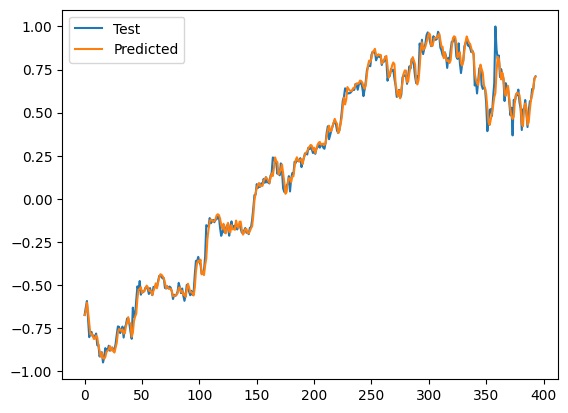

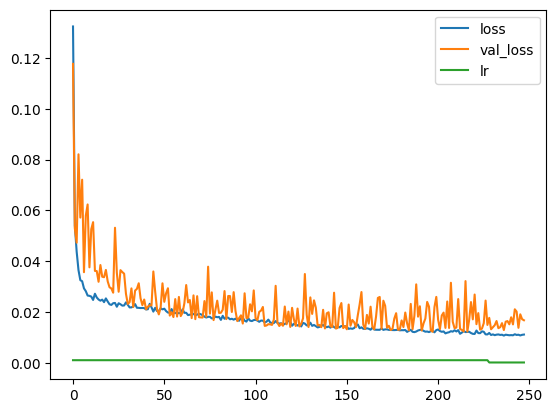

,type,best_val_loss,loss_method,optimizer,mae,mse,huber
0,Network6,0.012187,mae,AdamW,0.024979,0.001622,0.000811


In [30]:
test_network([
    keras.layers.Input(shape=(50,6)),
    keras.layers.LSTM(50),
    keras.layers.Dense(50),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(1),
])

Epoch 1/500
25/25 [==============================] - 2s 17ms/step - loss: 0.1134 - val_loss: 0.1624 - lr: 0.0010
Epoch 2/500
25/25 [==============================] - 0s 5ms/step - loss: 0.0382 - val_loss: 0.0811 - lr: 0.0010
Epoch 3/500
25/25 [==============================] - 0s 5ms/step - loss: 0.0305 - val_loss: 0.0663 - lr: 0.0010
Epoch 4/500
25/25 [==============================] - 0s 5ms/step - loss: 0.0285 - val_loss: 0.0722 - lr: 0.0010
Epoch 5/500
25/25 [==============================] - 0s 5ms/step - loss: 0.0274 - val_loss: 0.0553 - lr: 0.0010
Epoch 6/500
25/25 [==============================] - 0s 5ms/step - loss: 0.0268 - val_loss: 0.0693 - lr: 0.0010
Epoch 7/500
25/25 [==============================] - 0s 5ms/step - loss: 0.0250 - val_loss: 0.0649 - lr: 0.0010
Epoch 8/500
25/25 [==============================] - 0s 5ms/step - loss: 0.0242 - val_loss: 0.0578 - lr: 0.0010
Epoch 9/500
25/25 [==============================] - 0s 5ms/step - loss: 0.0225 - val_loss: 0.0564 - lr

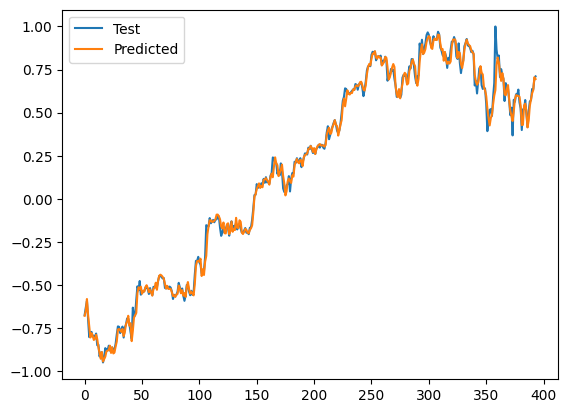

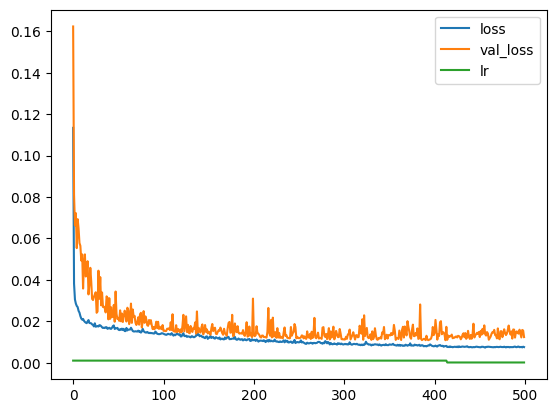

,type,best_val_loss,loss_method,optimizer,mae,mse,huber
0,Network2,0.010862,mae,AdamW,0.021298,0.001291,0.000645


In [34]:
test_network([
    keras.layers.Input(shape=(50,6)),
    keras.layers.LSTM(50),
    keras.layers.Dense(50),
    keras.layers.Dropout(0.05),
    keras.layers.Dense(1),
], lr_pat=50, es_pat=100)

Epoch 1/500
25/25 [==============================] - 2s 17ms/step - loss: 0.2121 - val_loss: 0.2093 - lr: 0.0010
Epoch 2/500
25/25 [==============================] - 0s 5ms/step - loss: 0.1156 - val_loss: 0.1893 - lr: 0.0010
Epoch 3/500
25/25 [==============================] - 0s 5ms/step - loss: 0.0920 - val_loss: 0.1681 - lr: 0.0010
Epoch 4/500
25/25 [==============================] - 0s 5ms/step - loss: 0.0761 - val_loss: 0.1589 - lr: 0.0010
Epoch 5/500
25/25 [==============================] - 0s 5ms/step - loss: 0.0658 - val_loss: 0.1346 - lr: 0.0010
Epoch 6/500
25/25 [==============================] - 0s 5ms/step - loss: 0.0573 - val_loss: 0.1405 - lr: 0.0010
Epoch 7/500
25/25 [==============================] - 0s 4ms/step - loss: 0.0512 - val_loss: 0.1296 - lr: 0.0010
Epoch 8/500
25/25 [==============================] - 0s 4ms/step - loss: 0.0463 - val_loss: 0.1170 - lr: 0.0010
Epoch 9/500
25/25 [==============================] - 0s 5ms/step - loss: 0.0422 - val_loss: 0.1121 - lr

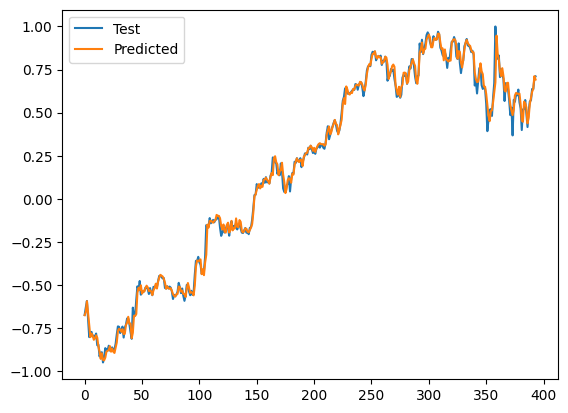

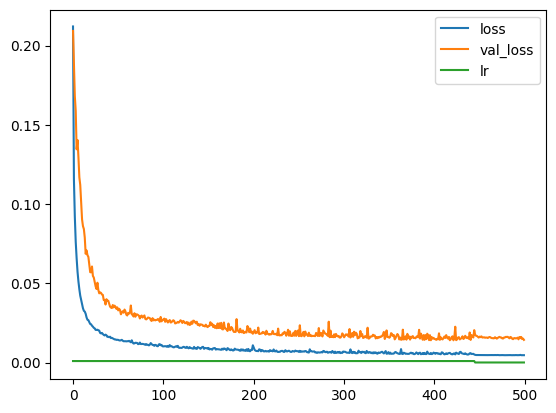

,type,best_val_loss,loss_method,optimizer,mae,mse,huber
0,Network3,0.014086,mae,AdamW,0.021758,0.00124,0.00062


In [35]:
test_network([
    keras.layers.Input(shape=(50,6)),
    keras.layers.LSTM(50, kernel_regularizer='l2'),
    keras.layers.Dense(1),
], lr_pat=50, es_pat=100)

Epoch 1/500
25/25 [==============================] - 2s 17ms/step - loss: 0.3299 - val_loss: 0.2284 - lr: 0.0010
Epoch 2/500
25/25 [==============================] - 0s 5ms/step - loss: 0.1426 - val_loss: 0.2381 - lr: 0.0010
Epoch 3/500
25/25 [==============================] - 0s 6ms/step - loss: 0.1188 - val_loss: 0.2353 - lr: 0.0010
Epoch 4/500
25/25 [==============================] - 0s 5ms/step - loss: 0.1026 - val_loss: 0.2228 - lr: 0.0010
Epoch 5/500
25/25 [==============================] - 0s 5ms/step - loss: 0.0880 - val_loss: 0.2294 - lr: 0.0010
Epoch 6/500
25/25 [==============================] - 0s 5ms/step - loss: 0.0791 - val_loss: 0.2410 - lr: 0.0010
Epoch 7/500
25/25 [==============================] - 0s 5ms/step - loss: 0.0713 - val_loss: 0.2506 - lr: 0.0010
Epoch 8/500
25/25 [==============================] - 0s 5ms/step - loss: 0.0673 - val_loss: 0.2288 - lr: 0.0010
Epoch 9/500
25/25 [==============================] - 0s 5ms/step - loss: 0.0640 - val_loss: 0.2314 - lr

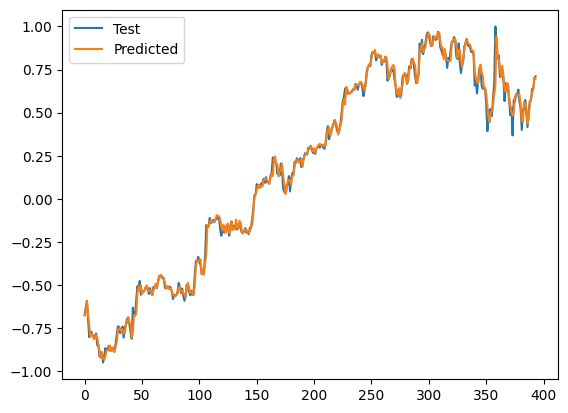

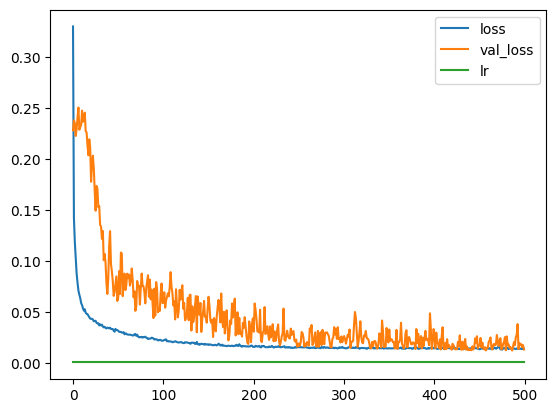

,type,best_val_loss,loss_method,optimizer,mae,mse,huber
0,Network4,0.012691,mae,AdamW,0.022299,0.001292,0.000646


In [36]:
test_network([
    keras.layers.Input(shape=(50,6)),
    keras.layers.LSTM(50, kernel_regularizer='l2'),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(1),
], lr_pat=50, es_pat=100)

Epoch 1/500
25/25 [==============================] - 2s 16ms/step - loss: 0.3295 - val_loss: 0.3339 - lr: 0.0010
Epoch 2/500
25/25 [==============================] - 0s 5ms/step - loss: 0.2068 - val_loss: 0.3000 - lr: 0.0010
Epoch 3/500
25/25 [==============================] - 0s 5ms/step - loss: 0.1760 - val_loss: 0.2626 - lr: 0.0010
Epoch 4/500
25/25 [==============================] - 0s 5ms/step - loss: 0.1580 - val_loss: 0.2576 - lr: 0.0010
Epoch 5/500
25/25 [==============================] - 0s 5ms/step - loss: 0.1464 - val_loss: 0.2601 - lr: 0.0010
Epoch 6/500
25/25 [==============================] - 0s 5ms/step - loss: 0.1341 - val_loss: 0.2644 - lr: 0.0010
Epoch 7/500
25/25 [==============================] - 0s 5ms/step - loss: 0.1244 - val_loss: 0.2333 - lr: 0.0010
Epoch 8/500
25/25 [==============================] - 0s 5ms/step - loss: 0.1181 - val_loss: 0.2079 - lr: 0.0010
Epoch 9/500
25/25 [==============================] - 0s 5ms/step - loss: 0.1134 - val_loss: 0.1984 - lr

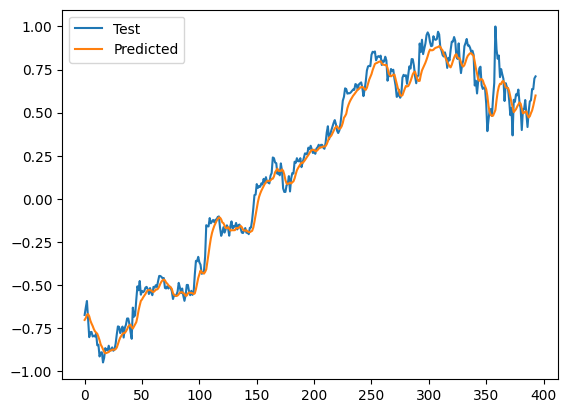

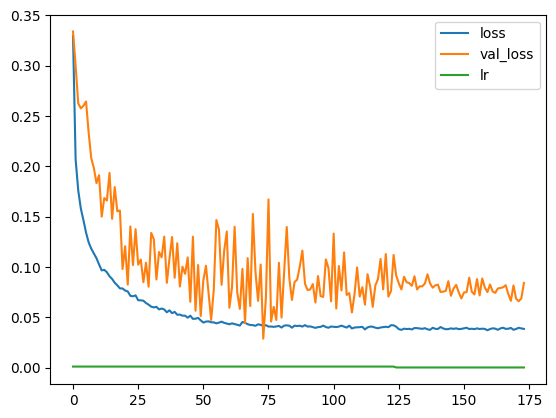

,type,best_val_loss,loss_method,optimizer,mae,mse,huber
0,Network6,0.028704,mae,AdamW,0.052201,0.005333,0.002667


In [38]:
test_network([
    keras.layers.Input(shape=(50,6)),
    keras.layers.LSTM(50, kernel_regularizer='l2'),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1),
], lr_pat=50, es_pat=100)

Epoch 1/500
25/25 [==============================] - 3s 28ms/step - loss: 0.1090 - val_loss: 0.3737 - lr: 0.0010
Epoch 2/500
25/25 [==============================] - 0s 8ms/step - loss: 0.0284 - val_loss: 0.3220 - lr: 0.0010
Epoch 3/500
25/25 [==============================] - 0s 7ms/step - loss: 0.0222 - val_loss: 0.2892 - lr: 0.0010
Epoch 4/500
25/25 [==============================] - 0s 7ms/step - loss: 0.0201 - val_loss: 0.2694 - lr: 0.0010
Epoch 5/500
25/25 [==============================] - 0s 7ms/step - loss: 0.0195 - val_loss: 0.2380 - lr: 0.0010
Epoch 6/500
25/25 [==============================] - 0s 7ms/step - loss: 0.0190 - val_loss: 0.2435 - lr: 0.0010
Epoch 7/500
25/25 [==============================] - 0s 7ms/step - loss: 0.0200 - val_loss: 0.2611 - lr: 0.0010
Epoch 8/500
25/25 [==============================] - 0s 7ms/step - loss: 0.0213 - val_loss: 0.2469 - lr: 0.0010
Epoch 9/500
25/25 [==============================] - 0s 7ms/step - loss: 0.0179 - val_loss: 0.2157 - lr

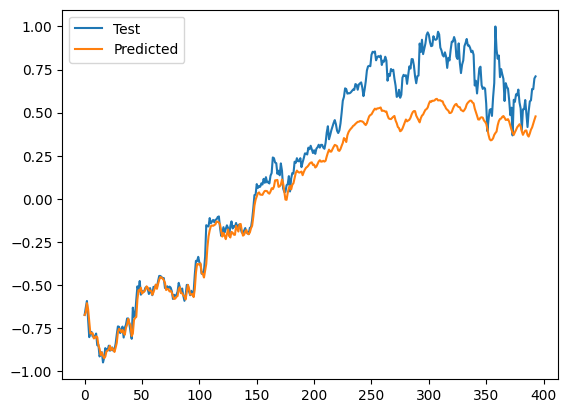

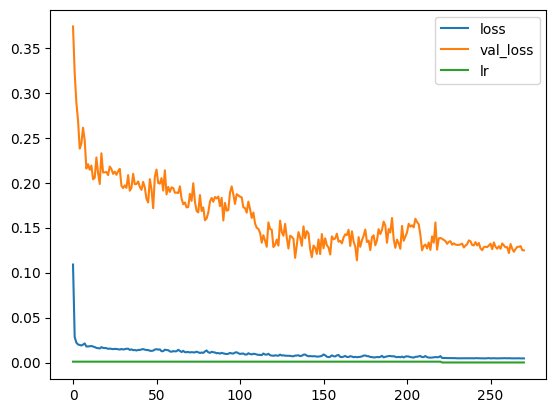

,type,best_val_loss,loss_method,optimizer,mae,mse,huber
0,Network12,0.11371,mae,AdamW,0.136898,0.034572,0.017286


In [46]:
test_network([
    keras.layers.Input(shape=(50,6)),
    keras.layers.LSTM(50, return_sequences=True),
    keras.layers.Dropout(0.1),
    keras.layers.LSTM(50),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dense(1),
], lr_pat=50, es_pat=100)

Epoch 1/500
25/25 [==============================] - 3s 27ms/step - loss: 0.1462 - val_loss: 0.1593 - lr: 0.0010
Epoch 2/500
25/25 [==============================] - 0s 7ms/step - loss: 0.0314 - val_loss: 0.1327 - lr: 0.0010
Epoch 3/500
25/25 [==============================] - 0s 7ms/step - loss: 0.0254 - val_loss: 0.1319 - lr: 0.0010
Epoch 4/500
25/25 [==============================] - 0s 7ms/step - loss: 0.0247 - val_loss: 0.1160 - lr: 0.0010
Epoch 5/500
25/25 [==============================] - 0s 7ms/step - loss: 0.0243 - val_loss: 0.1282 - lr: 0.0010
Epoch 6/500
25/25 [==============================] - 0s 7ms/step - loss: 0.0243 - val_loss: 0.1206 - lr: 0.0010
Epoch 7/500
25/25 [==============================] - 0s 7ms/step - loss: 0.0242 - val_loss: 0.1162 - lr: 0.0010
Epoch 8/500
25/25 [==============================] - 0s 9ms/step - loss: 0.0250 - val_loss: 0.1054 - lr: 0.0010
Epoch 9/500
25/25 [==============================] - 0s 7ms/step - loss: 0.0244 - val_loss: 0.0972 - lr

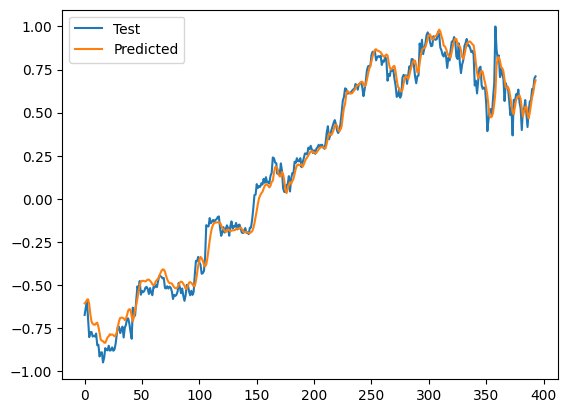

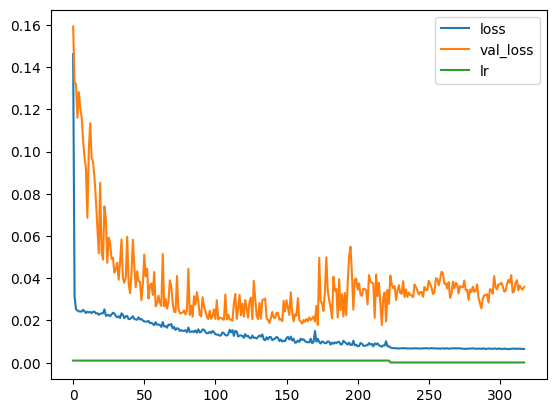

,type,best_val_loss,loss_method,optimizer,mae,mse,huber
0,Network13,0.017847,mae,AdamW,0.047588,0.003966,0.001983


In [48]:
test_network([
    keras.layers.Input(shape=(50,6)),
    keras.layers.Dropout(0.1),
    keras.layers.LSTM(50, return_sequences=True),
    keras.layers.LSTM(50),
    keras.layers.Dense(1),
], lr_pat=50, es_pat=100)

Epoch 1/500
25/25 [==============================] - 3s 27ms/step - loss: 0.1956 - val_loss: 0.0752 - lr: 0.0010
Epoch 2/500
25/25 [==============================] - 0s 7ms/step - loss: 0.0436 - val_loss: 0.0543 - lr: 0.0010
Epoch 3/500
25/25 [==============================] - 0s 7ms/step - loss: 0.0292 - val_loss: 0.0327 - lr: 0.0010
Epoch 4/500
25/25 [==============================] - 0s 7ms/step - loss: 0.0239 - val_loss: 0.0314 - lr: 0.0010
Epoch 5/500
25/25 [==============================] - 0s 7ms/step - loss: 0.0208 - val_loss: 0.0404 - lr: 0.0010
Epoch 6/500
25/25 [==============================] - 0s 6ms/step - loss: 0.0193 - val_loss: 0.0437 - lr: 0.0010
Epoch 7/500
25/25 [==============================] - 0s 7ms/step - loss: 0.0192 - val_loss: 0.0448 - lr: 0.0010
Epoch 8/500
25/25 [==============================] - 0s 6ms/step - loss: 0.0172 - val_loss: 0.0456 - lr: 0.0010
Epoch 9/500
25/25 [==============================] - 0s 6ms/step - loss: 0.0162 - val_loss: 0.0418 - lr

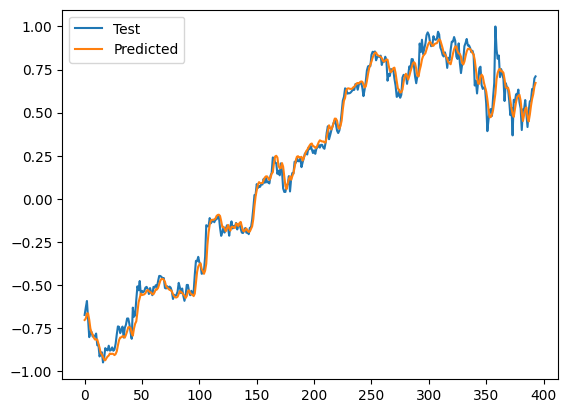

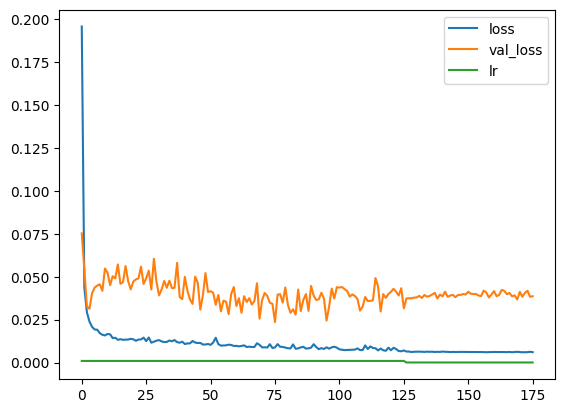

,type,best_val_loss,loss_method,optimizer,mae,mse,huber
0,Network14,0.023634,mae,AdamW,0.037613,0.002877,0.001438


In [49]:
test_network([
    keras.layers.Input(shape=(50,6)),
    keras.layers.GRU(50, return_sequences=True),
    keras.layers.Dropout(0.1),
    keras.layers.GRU(50),
    keras.layers.Dense(1),
], lr_pat=50, es_pat=100)

Epoch 1/500
25/25 [==============================] - 3s 24ms/step - loss: 0.0632 - val_loss: 0.0392 - lr: 0.0010
Epoch 2/500
25/25 [==============================] - 0s 7ms/step - loss: 0.0297 - val_loss: 0.0439 - lr: 0.0010
Epoch 3/500
25/25 [==============================] - 0s 7ms/step - loss: 0.0254 - val_loss: 0.0403 - lr: 0.0010
Epoch 4/500
25/25 [==============================] - 0s 6ms/step - loss: 0.0237 - val_loss: 0.0302 - lr: 0.0010
Epoch 5/500
25/25 [==============================] - 0s 6ms/step - loss: 0.0223 - val_loss: 0.0374 - lr: 0.0010
Epoch 6/500
25/25 [==============================] - 0s 6ms/step - loss: 0.0224 - val_loss: 0.0358 - lr: 0.0010
Epoch 7/500
25/25 [==============================] - 0s 6ms/step - loss: 0.0223 - val_loss: 0.0313 - lr: 0.0010
Epoch 8/500
25/25 [==============================] - 0s 6ms/step - loss: 0.0224 - val_loss: 0.0362 - lr: 0.0010
Epoch 9/500
25/25 [==============================] - 0s 6ms/step - loss: 0.0193 - val_loss: 0.0438 - lr

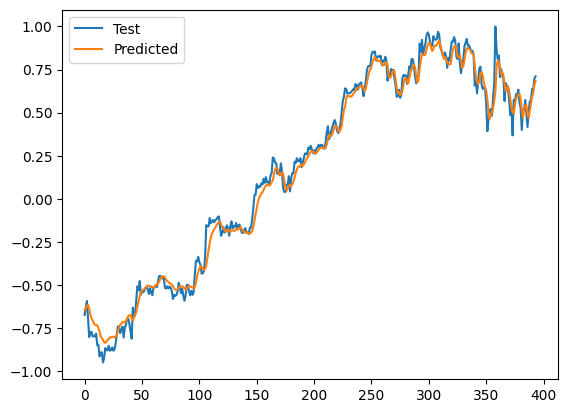

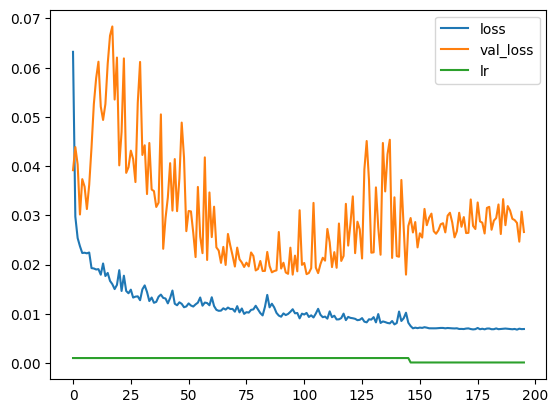

,type,best_val_loss,loss_method,optimizer,mae,mse,huber
0,Network15,0.017951,mae,AdamW,0.043649,0.003411,0.001705


In [50]:
test_network([
    keras.layers.Input(shape=(50,6)),
    keras.layers.Dropout(0.1),
    keras.layers.GRU(50, return_sequences=True),
    keras.layers.GRU(50),
    keras.layers.Dense(1),
], lr_pat=50, es_pat=100)

Epoch 1/500
25/25 [==============================] - 2s 18ms/step - loss: 0.2837 - val_loss: 0.5375 - lr: 0.0010
Epoch 2/500
25/25 [==============================] - 0s 5ms/step - loss: 0.1654 - val_loss: 0.4024 - lr: 0.0010
Epoch 3/500
25/25 [==============================] - 0s 5ms/step - loss: 0.1345 - val_loss: 0.4283 - lr: 0.0010
Epoch 4/500
25/25 [==============================] - 0s 5ms/step - loss: 0.1116 - val_loss: 0.4156 - lr: 0.0010
Epoch 5/500
25/25 [==============================] - 0s 5ms/step - loss: 0.0934 - val_loss: 0.4420 - lr: 0.0010
Epoch 6/500
25/25 [==============================] - 0s 5ms/step - loss: 0.0780 - val_loss: 0.4292 - lr: 0.0010
Epoch 7/500
25/25 [==============================] - 0s 5ms/step - loss: 0.0671 - val_loss: 0.4161 - lr: 0.0010
Epoch 8/500
25/25 [==============================] - 0s 6ms/step - loss: 0.0639 - val_loss: 0.3624 - lr: 0.0010
Epoch 9/500
25/25 [==============================] - 0s 6ms/step - loss: 0.0576 - val_loss: 0.2973 - lr

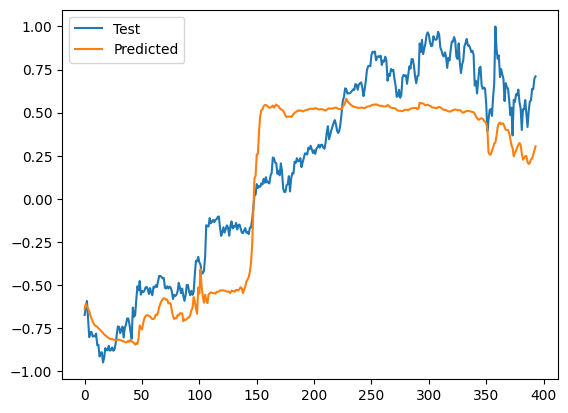

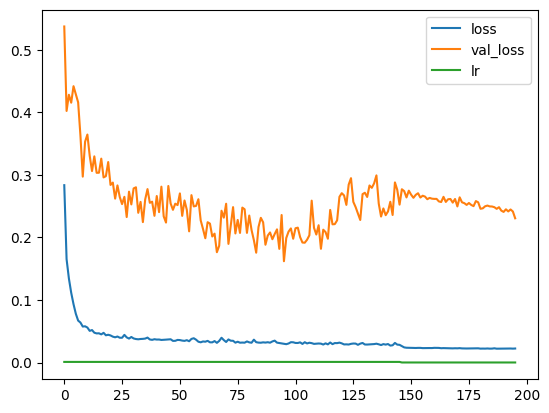

,type,best_val_loss,loss_method,optimizer,mae,mse,huber
0,Network16,0.162034,mae,AdamW,0.234499,0.069824,0.034912


In [51]:
test_network([
    keras.layers.Input(shape=(50,6)),
    keras.layers.LayerNormalization(),
    keras.layers.LSTM(50, kernel_regularizer='l2'),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dense(1),
], lr_pat=50, es_pat=100)

Epoch 1/500
25/25 [==============================] - 2s 40ms/step - loss: 1.0374 - val_loss: 1.0911 - lr: 0.0010
Epoch 2/500
25/25 [==============================] - 0s 5ms/step - loss: 0.7504 - val_loss: 0.8968 - lr: 0.0010
Epoch 3/500
25/25 [==============================] - 0s 5ms/step - loss: 0.5742 - val_loss: 0.6783 - lr: 0.0010
Epoch 4/500
25/25 [==============================] - 0s 5ms/step - loss: 0.4294 - val_loss: 0.5437 - lr: 0.0010
Epoch 5/500
25/25 [==============================] - 0s 5ms/step - loss: 0.3140 - val_loss: 0.4531 - lr: 0.0010
Epoch 6/500
25/25 [==============================] - 0s 5ms/step - loss: 0.2301 - val_loss: 0.3896 - lr: 0.0010
Epoch 7/500
25/25 [==============================] - 0s 5ms/step - loss: 0.1747 - val_loss: 0.3606 - lr: 0.0010
Epoch 8/500
25/25 [==============================] - 0s 5ms/step - loss: 0.1455 - val_loss: 0.3486 - lr: 0.0010
Epoch 9/500
25/25 [==============================] - 0s 5ms/step - loss: 0.1264 - val_loss: 0.3320 - lr

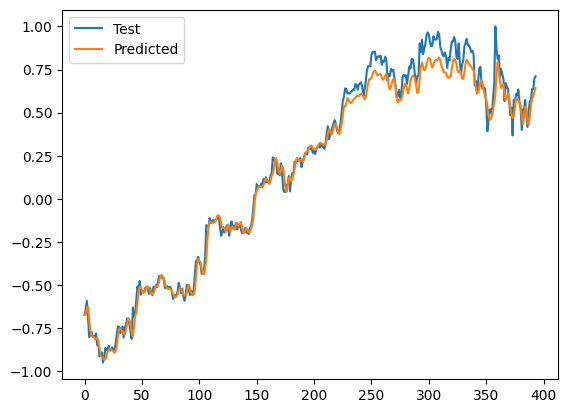

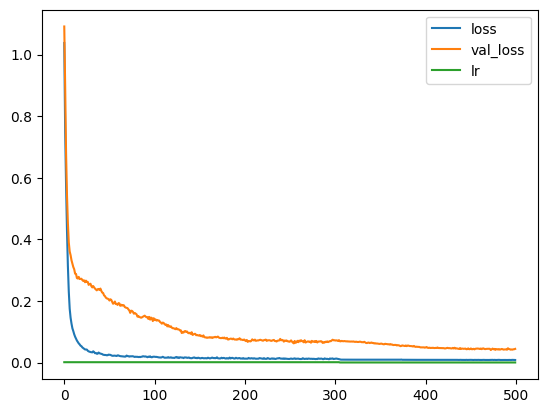

,type,best_val_loss,loss_method,optimizer,mae,mse,huber
0,Network17,0.040515,mae,AdamW,0.048459,0.004466,0.002233


In [52]:
test_network([
    keras.layers.Input(shape=(50,6)),
    keras.layers.LSTM(50, kernel_regularizer=keras.regularizers.L1(0.01)),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dense(1),
], lr_pat=50, es_pat=100)

Epoch 1/500
25/25 [==============================] - 2s 16ms/step - loss: 0.1682 - val_loss: 0.3353 - lr: 0.0010
Epoch 2/500
25/25 [==============================] - 0s 5ms/step - loss: 0.0759 - val_loss: 0.2930 - lr: 0.0010
Epoch 3/500
25/25 [==============================] - 0s 5ms/step - loss: 0.0610 - val_loss: 0.2628 - lr: 0.0010
Epoch 4/500
25/25 [==============================] - 0s 5ms/step - loss: 0.0512 - val_loss: 0.2291 - lr: 0.0010
Epoch 5/500
25/25 [==============================] - 0s 9ms/step - loss: 0.0456 - val_loss: 0.2424 - lr: 0.0010
Epoch 6/500
25/25 [==============================] - 0s 6ms/step - loss: 0.0409 - val_loss: 0.2295 - lr: 0.0010
Epoch 7/500
25/25 [==============================] - 0s 5ms/step - loss: 0.0376 - val_loss: 0.2198 - lr: 0.0010
Epoch 8/500
25/25 [==============================] - 0s 5ms/step - loss: 0.0348 - val_loss: 0.2297 - lr: 0.0010
Epoch 9/500
25/25 [==============================] - 0s 5ms/step - loss: 0.0324 - val_loss: 0.2130 - lr

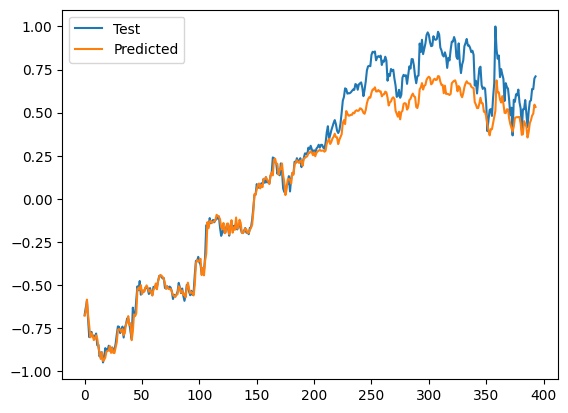

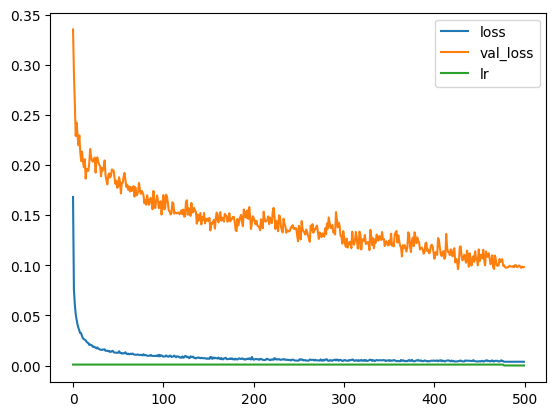

,type,best_val_loss,loss_method,optimizer,mae,mse,huber
0,Network18,0.096205,mae,AdamW,0.084369,0.014038,0.007019


In [55]:
test_network([
    keras.layers.Input(shape=(50,6)),
    keras.layers.LSTM(50, kernel_regularizer=keras.regularizers.L2(0.005)),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dense(1),
], lr_pat=50, es_pat=100)

Epoch 1/500
25/25 [==============================] - 2s 18ms/step - loss: 1.2052 - val_loss: 1.0712 - lr: 0.0010
Epoch 2/500
25/25 [==============================] - 0s 5ms/step - loss: 0.7966 - val_loss: 0.8190 - lr: 0.0010
Epoch 3/500
25/25 [==============================] - 0s 5ms/step - loss: 0.6190 - val_loss: 0.6427 - lr: 0.0010
Epoch 4/500
25/25 [==============================] - 0s 5ms/step - loss: 0.4676 - val_loss: 0.5086 - lr: 0.0010
Epoch 5/500
25/25 [==============================] - 0s 5ms/step - loss: 0.3430 - val_loss: 0.3979 - lr: 0.0010
Epoch 6/500
25/25 [==============================] - 0s 5ms/step - loss: 0.2506 - val_loss: 0.3061 - lr: 0.0010
Epoch 7/500
25/25 [==============================] - 0s 5ms/step - loss: 0.1908 - val_loss: 0.2543 - lr: 0.0010
Epoch 8/500
25/25 [==============================] - 0s 4ms/step - loss: 0.1548 - val_loss: 0.2244 - lr: 0.0010
Epoch 9/500
25/25 [==============================] - 0s 4ms/step - loss: 0.1319 - val_loss: 0.1946 - lr

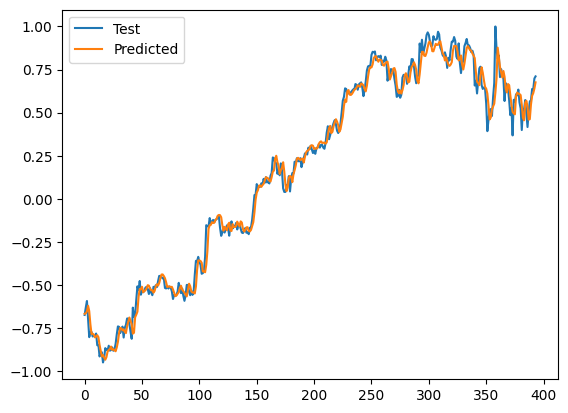

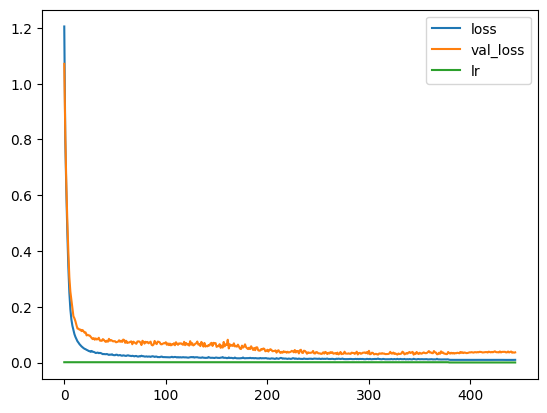

,type,best_val_loss,loss_method,optimizer,mae,mse,huber
0,Network19,0.028184,mae,AdamW,0.040827,0.003307,0.001654


In [56]:
test_network([
    keras.layers.Input(shape=(50,6)),
    keras.layers.LSTM(50, kernel_regularizer='l1'),
    keras.layers.Dense(1),
], lr_pat=50, es_pat=100)

## Rezultati

In [69]:
best_net = Out[36]

In [71]:
results = pd.DataFrame(results).iloc[9]
results

type             Network4
best_val_loss    0.012691
loss_method           mae
optimizer           AdamW
mae              0.022299
mse              0.001292
huber            0.000646
Name: 9, dtype: object

Najbolja nadjena mreza ima strukturu:
```python
[
    keras.layers.Input(shape=(50,6)),
    keras.layers.LSTM(50, kernel_regularizer='l2'),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(1),
]
```
Optimizer: AdamW.

Loss fn: Mean Absolute Error.

Sa ReduceLROnPlateau i EarlyStopping.

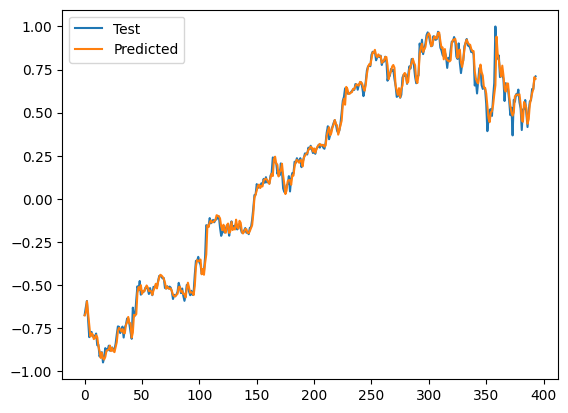